## **Implementation of Supervised Multimodal Bitransformers for Classifying Images and Text**

https://arxiv.org/pdf/1909.02950.pdf

Inspiration From : https://github.com/facebookresearch/mmbt
(Note: their repository has missing code "fragments" )

Replicated for a **Binary** Pipeline

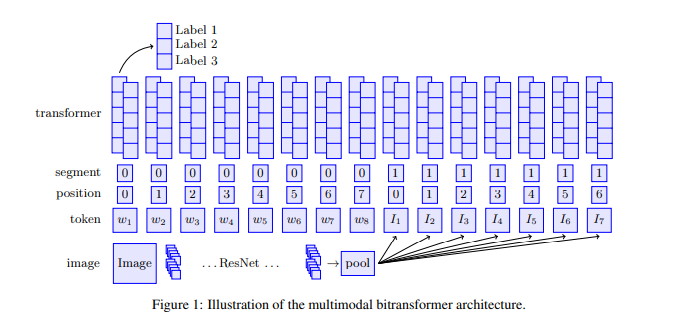


In [1]:

# !pip install pytorch-pretrained-bert

In [2]:
import pandas as pd 
import json
import jsonlines

# Prepare JSON files

In [ ]:
train_data = pd.read_csv("train_new_clean.csv")
test_data = pd.read_csv("test_new_clean.csv")
val_data = pd.read_csv("val_new_clean.csv")

#change path
train_data['poster_paths'] =train_data.id.apply(lambda x :  'img/img/'+str(x)+'.jpg')
test_data['poster_paths'] =test_data.id.apply(lambda x :  'img/img/'+str(x)+'.jpg')
val_data['poster_paths'] =val_data.id.apply(lambda x :  'img/img/'+str(x)+'.jpg')

In [ ]:
data_path  = 'data_json_files'

train_labels = set()

train = []

for index, row in train_data.iterrows():
    train.append(
        {
            "label": row['genre_list'],
            "img": row['poster_paths'],
            "description": row['description'],
            "origin_title": row['origin_title']
        }
    )
    for label in row['genre_list']:
        train_labels.add(label)
with jsonlines.open(f'{data_path}/train.jsonl', 'w') as writer:
    writer.write_all(train) 

    
val = []
for index, row in val_data.iterrows():
    val.append(
        {
            "label": row['genre_list'],
            "img": row['poster_paths'],
            "description": row['description'],
            "origin_title": row['origin_title']
        }
    )
with jsonlines.open(f'{data_path}/val.jsonl', 'w') as writer:
    writer.write_all(val)


test = []
for index, row in test_data.iterrows():
    test.append(
        {
            "label": row['genre_list'],
            "img": row['poster_paths'],
            "description": row['description'],
            "origin_title": row['origin_title']
        }
    )
with jsonlines.open(f'{data_path}/test.jsonl', 'w') as writer:
    writer.write_all(test)

-------------------------------------------

In [30]:
#@title Install Necessary Packages
!pip install pytorch-pretrained-bert

-----------------------------------------------------------

## Image Embeddings Functions


In [31]:
# @title Image Encoder

import torch
import torch.nn as nn
import torchvision

class ImageEncoder(nn.Module):
    def __init__(self, args):
        super(ImageEncoder, self).__init__()
        self.args = args
        model = torchvision.models.resnet152(pretrained=True)
        modules = list(model.children())[:-2]
        self.model = nn.Sequential(*modules)

        pool_func = (
            nn.AdaptiveAvgPool2d
            if args.img_embed_pool_type == "avg"
            else nn.AdaptiveMaxPool2d
        )

        if args.num_image_embeds in [1, 2, 3, 5, 7]:
            self.pool = pool_func((args.num_image_embeds, 1))
        elif args.num_image_embeds == 4:
            self.pool = pool_func((2, 2))
        elif args.num_image_embeds == 6:
            self.pool = pool_func((3, 2))
        elif args.num_image_embeds == 8:
            self.pool = pool_func((4, 2))
        elif args.num_image_embeds == 9:
            self.pool = pool_func((3, 3))


    def forward(self, x):
        # Bx3x224x224 -> Bx2048x7x7 -> Bx2048xN -> BxNx2048
        out = self.pool(self.model(x))
        out = torch.flatten(out, start_dim=2)
        out = out.transpose(1, 2).contiguous()
        return out  # BxNx2048




In [32]:
#@title Image Classifier


class ImageClf(nn.Module):
    def __init__(self, args):
        super(ImageClf, self).__init__()
        self.args = args
        self.img_encoder = ImageEncoder(args)
        self.clf = nn.Linear(args.img_hidden_sz * args.num_image_embeds, args.n_classes)

    def forward(self, x):
        x = self.img_encoder(x)
        x = torch.flatten(x, start_dim=1)
        out = self.clf(x)
        return out

        

--------------------------------------------------------------------------------

# Multi Modal BERT


In [33]:
#@title MMBERT ImageEmbeddings

import torch
import torch.nn as nn
from pytorch_pretrained_bert.modeling import BertModel

class ImageBertEmbeddings(nn.Module):
  def __init__(self,args,embeddings):
    super(ImageBertEmbeddings,self).__init__()
    self.args = args
    self.img_embeddings = nn.Linear(args.img_hidden_sz, args.hidden_sz)
    self.position_embeddings =embeddings.position_embeddings
    self.token_type_embeddings = embeddings.token_type_embeddings
    self.word_embeddings = embeddings.word_embeddings
    self.LayerNorm = embeddings.LayerNorm
    self.dropout = nn.Dropout(p=args.dropout)

  def forward(self, input_imgs, token_type_ids):
        bsz = input_imgs.size(0)
        seq_length = self.args.num_image_embeds + 2  # +2 for CLS and SEP Token

        cls_id = torch.LongTensor([self.args.vocab.stoi["[CLS]"]]).cuda()
        cls_id = cls_id.unsqueeze(0).expand(bsz, 1)
        cls_token_embeds = self.word_embeddings(cls_id)

        sep_id = torch.LongTensor([self.args.vocab.stoi["[SEP]"]]).cuda()
        sep_id = sep_id.unsqueeze(0).expand(bsz, 1)
        sep_token_embeds = self.word_embeddings(sep_id)

        imgs_embeddings = self.img_embeddings(input_imgs)
        token_embeddings = torch.cat(
            [cls_token_embeds, imgs_embeddings, sep_token_embeds], dim=1
        )

        position_ids = torch.arange(seq_length, dtype=torch.long).cuda()
        
        position_ids = position_ids.unsqueeze(0).expand(bsz, seq_length)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)
        embeddings = token_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings
     



In [34]:
#@title MM BertEncoder

class MultimodalBertEncoder(nn.Module):
    def __init__(self, args):
        super(MultimodalBertEncoder, self).__init__()
        self.args = args
        bert = BertModel.from_pretrained(args.bert_model)
        self.txt_embeddings = bert.embeddings

        self.img_embeddings = ImageBertEmbeddings(args, self.txt_embeddings)
        self.img_encoder = ImageEncoder(args)
        self.encoder = bert.encoder
        self.pooler = bert.pooler
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, input_txt, attention_mask, segment, input_img):
        bsz = input_txt.size(0)
        attention_mask = torch.cat(
            [
                torch.ones(bsz, self.args.num_image_embeds + 2).long().cuda(),
                attention_mask,
            ],
            dim=1,
        )
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(
            dtype=next(self.parameters()).dtype
        )
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        img_tok = (
            torch.LongTensor(input_txt.size(0), self.args.num_image_embeds + 2)
            .fill_(0)
            .cuda()
            
        )
        img = self.img_encoder(input_img)
        img_embed_out = self.img_embeddings(img, img_tok)
        txt_embed_out = self.txt_embeddings(input_txt, segment)

        encoder_input = torch.cat([img_embed_out, txt_embed_out], 1)

        encoded_layers = self.encoder(
            encoder_input, extended_attention_mask, output_all_encoded_layers=False
        )

        return self.pooler(encoded_layers[-1])


In [35]:
#@title MultiModal BERT Classifier Layer

class MultimodalBertClf(nn.Module):
    def __init__(self, args):
        super(MultimodalBertClf, self).__init__()
        self.args = args
        self.enc = MultimodalBertEncoder(args)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes)

    def forward(self, txt, mask, segment, img):
        x = self.enc(txt, mask, segment, img)
        return self.clf(x)
  

--------------------------------------------------------------------------------

##Helper Functions

In [36]:
#@title criterion
def get_criterion(args):
    if args.task_type == "multilabel":
        if args.weight_classes:
            freqs = [args.label_freqs[l] for l in args.labels]
            label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
            criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
        else:
            criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    return criterion

In [37]:
#@title Bert Optimizer

import torch.nn as nn
import torch.optim as optim
from pytorch_pretrained_bert import BertAdam

def get_optimizer(model, args):
    if args.model in ["bert", "concatbert", "mmbt"]:
        total_steps = (
            args.train_data_len
            / args.batch_sz
            / args.gradient_accumulation_steps
            * args.max_epochs
        )
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], "weight_decay": 0.01},
            {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], "weight_decay": 0.0,},
        ]
        optimizer = BertAdam(
            optimizer_grouped_parameters,
            lr=args.lr,
            warmup=args.warmup,
            t_total=total_steps,
        )
    else:
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

    return optimizer

  
      

In [38]:
#@title scheduler
def get_scheduler(optimizer, args):
    return optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, verbose=True, factor=args.lr_factor
    )

In [39]:
#@title loggers

import logging
import time
from datetime import timedelta


class LogFormatter:
    def __init__(self):
        self.start_time = time.time()

    def format(self, record):
        elapsed_seconds = round(record.created - self.start_time)

        prefix = "%s - %s - %s" % (
            record.levelname,
            time.strftime("%x %X"),
            timedelta(seconds=elapsed_seconds),
        )
        message = record.getMessage()
        message = message.replace("\n", "\n" + " " * (len(prefix) + 3))
        return "%s - %s" % (prefix, message)


def create_logger(filepath, args):
    # create log formatter
    log_formatter = LogFormatter()

    # create file handler and set level to debug
    file_handler = logging.FileHandler(filepath, "a")
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(log_formatter)

    # create console handler and set level to info
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(log_formatter)

    # create logger and set level to debug
    logger = logging.getLogger()
    logger.handlers = []
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    # reset logger elapsed time
    def reset_time():
        log_formatter.start_time = time.time()

    logger.reset_time = reset_time

    logger.info(
        "\n".join(
            "%s: %s" % (k, str(v))
            for k, v in sorted(dict(vars(args)).items(), key=lambda x: x[0])
        )
    )

    return logger

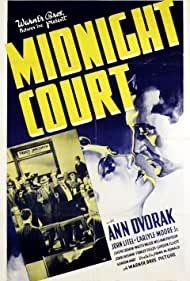

In [41]:
Image.open(
                    os.path.join('../input/imdb-genres-classification/img', 'img/29238.jpg')
                ).convert("RGB")

In [42]:
# @title Helper Functions: 
#@markdown get_data_loaders()
#

import functools
import json
import os
from collections import Counter

import torch
import torchvision.transforms as transforms
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import DataLoader

import json
import numpy as np
import os
from PIL import Image

import torch
from torch.utils.data import Dataset


import contextlib
import numpy as np
import random
import shutil
import os

import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))


def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])


def truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length.
    Copied from https://github.com/huggingface/pytorch-pretrained-BERT
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def store_preds_to_disk(tgts, preds, args):
    with open(os.path.join(args.savedir, "test_labels_pred.txt"), "w") as fw:
        fw.write(
            "\n".join([" ".join(["1" if x else "0" for x in p]) for p in preds])
        )
    with open(os.path.join(args.savedir, "test_labels_gold.txt"), "w") as fw:
        fw.write(
            "\n".join([" ".join(["1" if x else "0" for x in t]) for t in tgts])
        )
    with open(os.path.join(args.savedir, "test_labels.txt"), "w") as fw:
        fw.write(" ".join([l for l in args.labels]))



def log_metrics(set_name, metrics, args, logger):
    logger.info(
        "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f} | Recall: {:.5f} | Precision: {:.5f} | Accuracy {:.5}| Hamming loss {:.5}  ".format(
            set_name, metrics["loss"], metrics["macro_f1"], metrics["micro_f1"],
                metrics["recall"], metrics["precision score"], metrics["accuracy"], metrics['Hamming loss'] 
        
            
        
    )
        
    )

@contextlib.contextmanager
def numpy_seed(seed, *addl_seeds):
    """Context manager which seeds the NumPy PRNG with the specified seed and
    restores the state afterward"""
    if seed is None:
        yield
        return
    if len(addl_seeds) > 0:
        seed = int(hash((seed, *addl_seeds)) % 1e6)
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)


class JsonlDataset(Dataset):
    def __init__(self, data_path, tokenizer, transforms, vocab, args):
        self.data = [json.loads(l) for l in open(data_path)]
        self.data_dir = os.path.dirname(data_path)
        self.tokenizer = tokenizer
        self.args = args
        self.vocab = vocab
        self.n_classes = len(args.labels)
        self.text_start_token = ["[CLS]"] if args.model != "mmbt" else ["[SEP]"]

        with numpy_seed(0):
            for row in self.data:
                if np.random.random() < args.drop_img_percent:
                    row["img"] = None

        self.max_seq_len = args.max_seq_len
        if args.model == "mmbt":
            self.max_seq_len -= args.num_image_embeds

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = (
            self.text_start_token
            + self.tokenizer(self.data[index]["description"])[
                : (self.args.max_seq_len - 1)
            ]
        )
        segment = torch.zeros(len(sentence))

        sentence = torch.LongTensor(
            [
                self.vocab.stoi[w] if w in self.vocab.stoi else self.vocab.stoi["[UNK]"]
                for w in sentence
            ]
        )

        label = torch.zeros(self.n_classes)
        label[
            [self.args.labels.index(tgt) for tgt in self.data[index]["label"]]
        ] = 1

        image = None
        if self.args.model in ["img", "concatbow", "concatbert", "mmbt"]:
            image = Image.open(
                os.path.join(self.data_dir, self.data[index]["img"])
            ).convert("RGB")
            image = self.transforms(image)

        # The first SEP is part of Image Token.
        segment = segment[1:]
        sentence = sentence[1:]
        # The first segment (0) is of images.
        segment += 1

        return sentence, segment, image, label



class Vocab(object):
    def __init__(self, emptyInit=False):
        if emptyInit:
            self.stoi, self.itos, self.vocab_sz = {}, [], 0
        else:
            self.stoi = {
                w: i
                for i, w in enumerate(["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
            }
            self.itos = [w for w in self.stoi]
            self.vocab_sz = len(self.itos)

    def add(self, words):
        cnt = len(self.itos)
        for w in words:
            if w in self.stoi:
                continue
            self.stoi[w] = cnt
            self.itos.append(w)
            cnt += 1
        self.vocab_sz = len(self.itos)


def get_transforms(args):
    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.46777044, 0.44531429, 0.40661017],
                std=[0.12221994, 0.12145835, 0.14380469],
            ),
        ]
    )


def get_labels_and_frequencies(path):
    label_freqs = Counter()
    data_labels = [json.loads(line)["label"] for line in open(path)]
    
    for label_row in data_labels:
        label_freqs.update(label_row)

    return list(label_freqs.keys()), label_freqs


def get_glove_words(path):
    word_list = []
    for line in open(path):
        w, _ = line.split(" ", 1)
        word_list.append(w)
    return word_list


def get_vocab(args):
    vocab = Vocab()
    bert_tokenizer = BertTokenizer.from_pretrained(
        args.bert_model, do_lower_case=True
    )
    vocab.stoi = bert_tokenizer.vocab
    vocab.itos = bert_tokenizer.ids_to_tokens
    vocab.vocab_sz = len(vocab.itos)


    return vocab


def collate_fn(batch, args):
    lens = [len(row[0]) for row in batch]
    bsz, max_seq_len = len(batch), max(lens)

    mask_tensor = torch.zeros(bsz, max_seq_len).long()
    text_tensor = torch.zeros(bsz, max_seq_len).long()
    segment_tensor = torch.zeros(bsz, max_seq_len).long()

    img_tensor = None
    mg_tensor = torch.stack([row[2] for row in batch])

    # Multilabel case
    tgt_tensor = torch.stack([row[3] for row in batch])

    for i_batch, (input_row, length) in enumerate(zip(batch, lens)):
        tokens, segment = input_row[:2]
        text_tensor[i_batch, :length] = tokens
        segment_tensor[i_batch, :length] = segment
        mask_tensor[i_batch, :length] = 1

    return text_tensor, segment_tensor, mask_tensor, img_tensor, tgt_tensor


def get_data_loaders(args):
    tokenizer = (
        BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True).tokenize
        if args.model in ["bert", "mmbt", "concatbert"]
        else str.split
    )

    transforms = get_transforms(args)

    args.labels, args.label_freqs = get_labels_and_frequencies(
        os.path.join(args.data_path, "train_2000.jsonl")
    )
    vocab = get_vocab(args)
    args.vocab = vocab
    args.vocab_sz = vocab.vocab_sz
    args.n_classes = len(args.labels)

    train = JsonlDataset(
        os.path.join(args.data_path, "train_2000.jsonl"),
        tokenizer,
        transforms,
        vocab,
        args,
    )

    args.train_data_len = len(train)

    dev = JsonlDataset(
        os.path.join(args.data_path,  "dev_seen_2000.jsonl"),
        tokenizer,
        transforms,
        vocab,
        args,
    )

    collate = functools.partial(collate_fn, args=args)

    train_loader = DataLoader(
        train,
        batch_size=args.batch_sz,
        shuffle=True,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

    val_loader = DataLoader(
        dev,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

    test_set = JsonlDataset(
        os.path.join(args.data_path, "test_seen_2000.jsonl"),
        tokenizer,
        transforms,
        vocab,
        args,
    )

    test_loader = DataLoader(
        test_set,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

    test_gt = JsonlDataset(
        os.path.join(args.data_path,  "test_unseen_2000.jsonl"),
        tokenizer,
        transforms,
        vocab,
        args,
    )

    test_gt_loader = DataLoader(
        test_gt,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

    test = {
        "test": test_loader,
        "test_gt": test_gt_loader,
    }

    return train_loader, val_loader, test


In [43]:
#@title model forward during training

def model_forward(i_epoch, model, args, criterion, batch):
    txt, segment, mask, img, tgt = batch

    freeze_img = i_epoch < args.freeze_img
    freeze_txt = i_epoch < args.freeze_txt

    if args.model == "bow":
        txt = txt.cuda()
        out = model(txt)
    elif args.model == "img":
        img = img.cuda()
        out = model(img)
    elif args.model == "concatbow":
        txt, img = txt.cuda(), img.cuda()
        out = model(txt, img)
    elif args.model == "bert":
        txt, mask, segment = txt.cuda(), mask.cuda(), segment.cuda()
        out = model(txt, mask, segment)
    elif args.model == "concatbert":
        txt, img = txt.cuda(), img.cuda()
        mask, segment = mask.cuda(), segment.cuda()
        out = model(txt, mask, segment, img)
    else:
        assert args.model == "mmbt"
        for param in model.enc.img_encoder.parameters():
            param.requires_grad = not freeze_img
        for param in model.enc.encoder.parameters():
            param.requires_grad = not freeze_txt

        txt, img = txt.cuda(), img.cuda()
        mask, segment = mask.cuda(), segment.cuda()
        out = model(txt, mask, segment, img)

    tgt = tgt.cuda()
    loss = criterion(out, tgt)
    return loss, out, tgt


--------------------------------------------------------------------------------

### Training



In [44]:
#@title model_eval()

from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score,hamming_loss
from tqdm import tqdm

def model_eval(i_epoch, data, model, args, criterion, store_preds=False):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        for batch in data:
            loss, out, tgt = model_forward(i_epoch, model, args, criterion, batch)
            losses.append(loss.item())

            pred = torch.sigmoid(out).cpu().detach().numpy() > 0.5

            preds.append(pred)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    metrics = {"loss": np.mean(losses)}
    if args.task_type == "multilabel":
        tgts = np.vstack(tgts)
        preds = np.vstack(preds)
        metrics["macro_f1"] = f1_score(tgts, preds, average="macro")
        metrics["micro_f1"] = f1_score(tgts, preds, average="micro")
        metrics['recall'] = recall_score(tgts, preds, average='samples')
        metrics['precision score'] = precision_score(tgts, preds, average='samples')
        metrics['accuracy'] = accuracy_score(tgts, preds)
        metrics['Hamming loss'] =  hamming_loss(tgts, preds)
    else:
        tgts = [l for sl in tgts for l in sl]
        preds = [l for sl in preds for l in sl]
        metrics["acc"] = accuracy_score(tgts, preds)

    if store_preds:
        store_preds_to_disk(tgts, preds, args)

    return metrics

In [45]:
def get_model(args):
    return MultimodalBertClf(args)

In [46]:
#@title train function

from tqdm import tqdm

def train(args):

    set_seed(args.seed)
    args.savedir = os.path.join(args.savedir, args.name)
    os.makedirs(args.savedir, exist_ok=True)

    train_loader, val_loader, test_loaders = get_data_loaders(args)

    model = get_model(args)
    criterion = get_criterion(args) #criteria for loss
    optimizer = get_optimizer(model, args) #adam optimizer
    scheduler = get_scheduler(optimizer, args) #Scheduler

    logger = create_logger("%s/logfile.log" % args.savedir, args)
    logger.info(model)
    model.cuda()

    torch.save(args, os.path.join(args.savedir, "args.pt"))

    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

    logger.info("Training..")
    
    for i_epoch in  range(start_epoch, args.max_epochs) :
        train_losses = []
        model.train()
        optimizer.zero_grad()

        for batch in tqdm(train_loader, total=len(train_loader)):
        
            loss, _, _ = model_forward(i_epoch, model, args, criterion, batch)
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            train_losses.append(loss.item())
            loss.backward()
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval()
        metrics = model_eval(i_epoch, val_loader, model, args, criterion)
        logger.info("Train Loss: {:.4f}".format(np.mean(train_losses)))
        log_metrics("Val", metrics, args, logger)
        print(
            "{}: Loss: {:.5f} | Macro F1 {:.5f} | Micro F1: {:.5f} | Recall: {:.5f} | Precision: {:.5f} | Accuracy: {:.5f}| Hamming Lose {:.5f}".format(
                "Val", metrics["loss"], metrics["macro_f1"], metrics["micro_f1"], metrics["recall"], metrics["precision score"], metrics["accuracy"],
                metrics['Hamming loss'] 
            )
        )

        tuning_metric = (
            metrics["micro_f1"] if args.task_type == "multilabel" else metrics["acc"]
        )
        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
            logger.info("No improvement. Breaking out of loop.")
            break

    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()
    for test_name, test_loader in test_loaders.items():
        test_metrics = model_eval(
            np.inf, test_loader, model, args, criterion, store_preds=True
        )
        log_metrics(f"Test - {test_name}", test_metrics, args, logger)


In [47]:
#@title Arguments
#@markdown this is where you change your HyperParametres
import argparse

parser = argparse.ArgumentParser(description="Train Models")

parser.add_argument("--batch_sz", type=int, default=16)
parser.add_argument("--bert_model", type=str, default="bert-base-uncased", choices=["bert-base-uncased", "bert-large-uncased"])
parser.add_argument("--data_path", type=str, default="../input/imdb-genres-classification")
parser.add_argument("--drop_img_percent", type=float, default=0.0)
parser.add_argument("--dropout", type=float, default=0.1)
parser.add_argument("--embed_sz", type=int, default=100)
parser.add_argument("--freeze_img", type=int, default=0)
parser.add_argument("--freeze_txt", type=int, default=0)
parser.add_argument("--glove_path", type=str, default="/path/to/glove_embeds/glove.840B.300d.txt")
parser.add_argument("--gradient_accumulation_steps", type=int, default=20)
parser.add_argument("--hidden", nargs="*", type=int, default=[])
parser.add_argument("--hidden_sz", type=int, default=768)
parser.add_argument("--img_embed_pool_type", type=str, default="avg", choices=["max", "avg"])
parser.add_argument("--img_hidden_sz", type=int, default=2048)
parser.add_argument("--include_bn", type=int, default=True)
parser.add_argument("--lr", type=float, default=1e-4)
parser.add_argument("--lr_factor", type=float, default=0.5)
parser.add_argument("--lr_patience", type=int, default=2)
parser.add_argument("--max_epochs", type=int, default=6)
parser.add_argument("--max_seq_len", type=int, default=512)
parser.add_argument("--model", type=str, default="mmbt", choices=["bow", "img", "bert", "concatbow", "concatbert", "mmbt"])
parser.add_argument("--n_workers", type=int, default=0)
parser.add_argument("--n_classes", type=int, default=23)

parser.add_argument("--name", type=str, default="mmbt")

parser.add_argument("--num_image_embeds", type=int, default=1)
parser.add_argument("--patience", type=int, default=5)
parser.add_argument("--savedir", type=str, default="./")
parser.add_argument("--seed", type=int, default=123)
parser.add_argument("--task", type=str, default="mmimdb", choices=["mmimdb", "vsnli", "food101"])
parser.add_argument("--task_type", type=str, default="multilabel", choices=["multilabel", "classification"])
parser.add_argument("--warmup", type=float, default=0.1)
parser.add_argument("--weight_classes", type=int, default=1)

args, remaining_args = parser.parse_known_args()


In [48]:
args

Namespace(batch_sz=16, bert_model='bert-base-uncased', data_path='../input/imdb-genres-classification', drop_img_percent=0.0, dropout=0.1, embed_sz=100, freeze_img=0, freeze_txt=0, glove_path='/path/to/glove_embeds/glove.840B.300d.txt', gradient_accumulation_steps=20, hidden=[], hidden_sz=768, img_embed_pool_type='avg', img_hidden_sz=2048, include_bn=True, lr=0.0001, lr_factor=0.5, lr_patience=2, max_epochs=6, max_seq_len=512, model='concatbert', n_classes=23, n_workers=0, name='mmbt', num_image_embeds=1, patience=5, savedir='./', seed=123, task='mmimdb', task_type='multilabel', warmup=0.1, weight_classes=1)

In [49]:
remaining_args

['-f',
 '/root/.local/share/jupyter/runtime/kernel-fd52e235-9d5f-48bd-97c2-64d68272c112.json']

### **RUN**

In [50]:
import warnings

warnings.filterwarnings("ignore")



In [51]:
train(args)

INFO - 11/19/22 07:20:18 - 0:13:49 - loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO - 11/19/22 07:20:19 - 0:13:49 - loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
INFO - 11/19/22 07:20:20 - 0:13:50 - loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /root/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO - 11/19/22 07:20:20 - 0:13:50 - extracting archive fi